# Predict Wind Speed

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import pickle

c:\Users\louis\anaconda3\envs\ai\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Data Loading

In [2]:
data_path = (
    Path.cwd().parent.parent.parent.parent  # Repository root
    / "data"
    / "weather"
    / "open_meteo.csv"
)

In [160]:
df = pd.read_csv(data_path)

In [161]:
df.head()

,time,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,...,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration,latitude,longitude,elevation,country,city
0,2010-01-01,1,30.3,17.2,23.5,31.5,17.7,23.9,2010-01-01T00:04,2010-01-01T11:13,...,0.0,9.3,18.7,316,4.14,16.800003,96.20001,12.0,Myanmar,Yangoon
1,2010-01-02,1,30.9,16.8,23.6,30.6,16.6,23.4,2010-01-02T00:04,2010-01-02T11:13,...,0.0,12.8,27.7,342,4.77,16.800003,96.20001,12.0,Myanmar,Yangoon
2,2010-01-03,1,30.7,17.7,23.5,30.1,16.1,22.6,2010-01-03T00:05,2010-01-03T11:14,...,0.0,13.3,26.6,338,4.96,16.800003,96.20001,12.0,Myanmar,Yangoon
3,2010-01-04,3,30.8,17.6,24.2,30.7,16.8,24.2,2010-01-04T00:05,2010-01-04T11:14,...,0.0,12.1,25.6,327,4.57,16.800003,96.20001,12.0,Myanmar,Yangoon
4,2010-01-05,3,31.4,21.0,25.8,32.9,21.9,27.2,2010-01-05T00:05,2010-01-05T11:15,...,0.0,8.9,22.0,351,3.65,16.800003,96.20001,12.0,Myanmar,Yangoon


## Data Preprocessing

### Select a City

In [162]:
df['city'].value_counts()

Yangoon        4916
Mandalay       4916
Nay Pyi Taw    4916
Hpa-An         4916
Maungdaw       4916
Taunggyi       4916
Magway         4916
Myeik          4916
Keng Tung      4916
Laukkaing      4916
Name: city, dtype: int64

In [163]:
data = df[df['city'] == 'Yangoon']

In [164]:
data['city'].value_counts()

Yangoon    4916
Name: city, dtype: int64

### Extract Date and Windspeed

In [165]:
data.columns

Index(['time', 'weathercode', 'temperature_2m_max', 'temperature_2m_min',
       'temperature_2m_mean', 'apparent_temperature_max',
       'apparent_temperature_min', 'apparent_temperature_mean', 'sunrise',
       'sunset', 'shortwave_radiation_sum', 'precipitation_sum', 'rain_sum',
       'snowfall_sum', 'precipitation_hours', 'windspeed_10m_max',
       'windgusts_10m_max', 'winddirection_10m_dominant',
       'et0_fao_evapotranspiration', 'latitude', 'longitude', 'elevation',
       'country', 'city'],
      dtype='object')

In [166]:
data = data[['time', 'windspeed_10m_max']]
data.columns = ['ds', 'y']
data['ds'] = pd.to_datetime(data['ds'])
data.head()

,ds,y
0,2010-01-01,9.3
1,2010-01-02,12.8
2,2010-01-03,13.3
3,2010-01-04,12.1
4,2010-01-05,8.9


In [167]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4916 entries, 0 to 4915
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4916 non-null   datetime64[ns]
 1   y       4916 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 115.2 KB


### Split into Train-Test Data

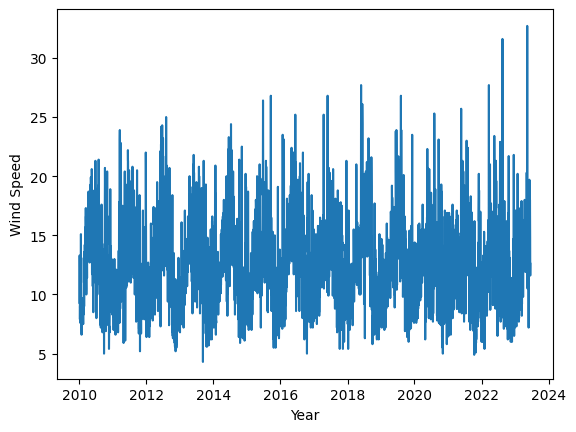

In [168]:
plt.plot(data['ds'], data['y'])
plt.xlabel('Year')
plt.ylabel('Wind Speed')
plt.show()

In [169]:
data['year'] = data['ds'].apply(lambda x: x.year)
data['year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023], dtype=int64)

In [170]:
data.isnull().any()

ds      False
y       False
year    False
dtype: bool

In [171]:
train_data = data[data['year'] <= 2020]
train_data.drop('year', axis=1, inplace=True)
test_data = data[data['year'] > 2020]
test_data.drop('year', axis=1, inplace=True)

C:\Users\louis\AppData\Local\Temp\ipykernel_12244\1353116500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop('year', axis=1, inplace=True)
C:\Users\louis\AppData\Local\Temp\ipykernel_12244\1353116500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop('year', axis=1, inplace=True)


In [172]:
train_data

,ds,y
0,2010-01-01,9.3
1,2010-01-02,12.8
2,2010-01-03,13.3
3,2010-01-04,12.1
4,2010-01-05,8.9
...,...,...
4013,2020-12-27,7.9
4014,2020-12-28,9.4
4015,2020-12-29,9.1
4016,2020-12-30,10.4


In [173]:
test_data

,ds,y
4018,2021-01-01,16.5
4019,2021-01-02,13.0
4020,2021-01-03,8.8
4021,2021-01-04,11.3
4022,2021-01-05,9.8
...,...,...
4911,2023-06-13,18.0
4912,2023-06-14,16.9
4913,2023-06-15,14.8
4914,2023-06-16,11.6


## Data Modeling and Evaluation

### Training

In [174]:
model = Prophet()
model.fit(train_data)

15:18:51 - cmdstanpy - INFO - Chain [1] start processing
15:18:51 - cmdstanpy - INFO - Chain [1] done processing


### Predict Future Windspeed

In [175]:
future = model.make_future_dataframe(periods=test_data.shape[0])
future.tail()

,ds
4911,2023-06-13
4912,2023-06-14
4913,2023-06-15
4914,2023-06-16
4915,2023-06-17


In [176]:
test_data.tail()

,ds,y
4911,2023-06-13,18.0
4912,2023-06-14,16.9
4913,2023-06-15,14.8
4914,2023-06-16,11.6
4915,2023-06-17,12.6


In [177]:
forecast = model.predict(future)

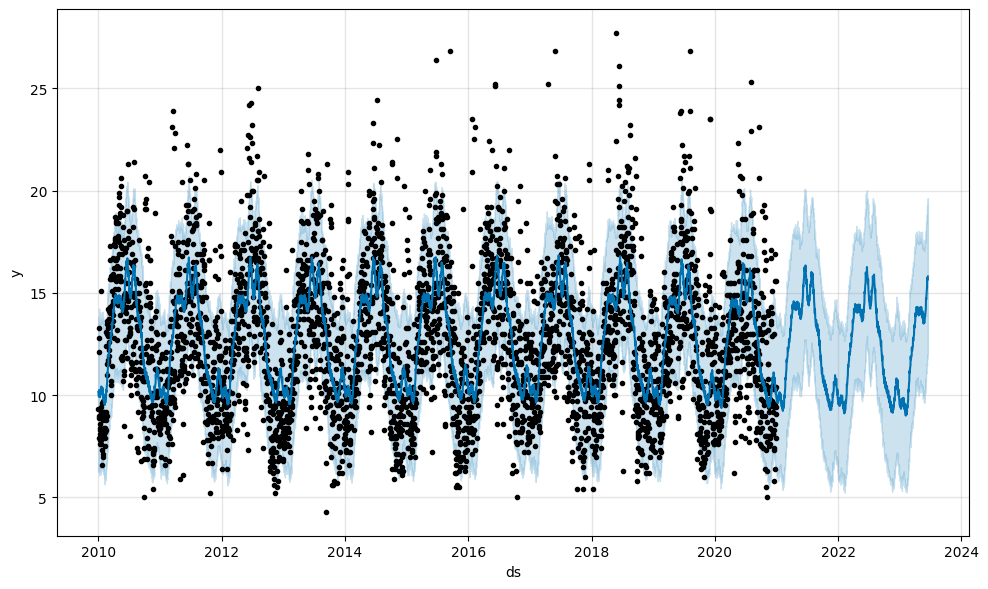

In [178]:
fig1 = model.plot(forecast)

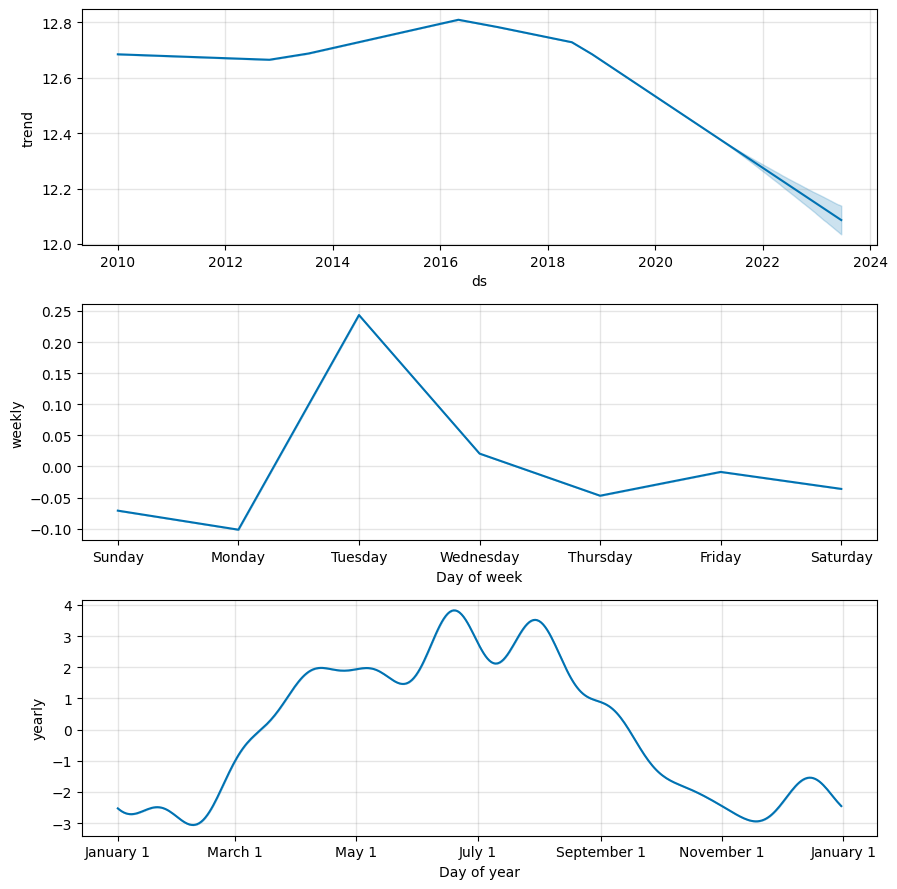

In [179]:
fig2 = model.plot_components(forecast)

### Compare Forecast and Real Data

In [180]:
forecast = forecast[['ds', 'yhat']]
forecast['year'] = forecast['ds'].apply(lambda x: x.year)
forecast = forecast[forecast['year'] > 2020]
forecast.drop('year', axis=1, inplace=True)
forecast['yhat'] = forecast['yhat'].apply(lambda x: round(x, 1))
forecast.columns = ['date', 'forecast']
forecast['real'] = test_data['y']
forecast

,date,forecast,real
4018,2021-01-01,9.9,16.5
4019,2021-01-02,9.8,13.0
4020,2021-01-03,9.7,8.8
4021,2021-01-04,9.6,11.3
4022,2021-01-05,10.0,9.8
...,...,...,...
4911,2023-06-13,15.7,18.0
4912,2023-06-14,15.6,16.9
4913,2023-06-15,15.6,14.8
4914,2023-06-16,15.8,11.6


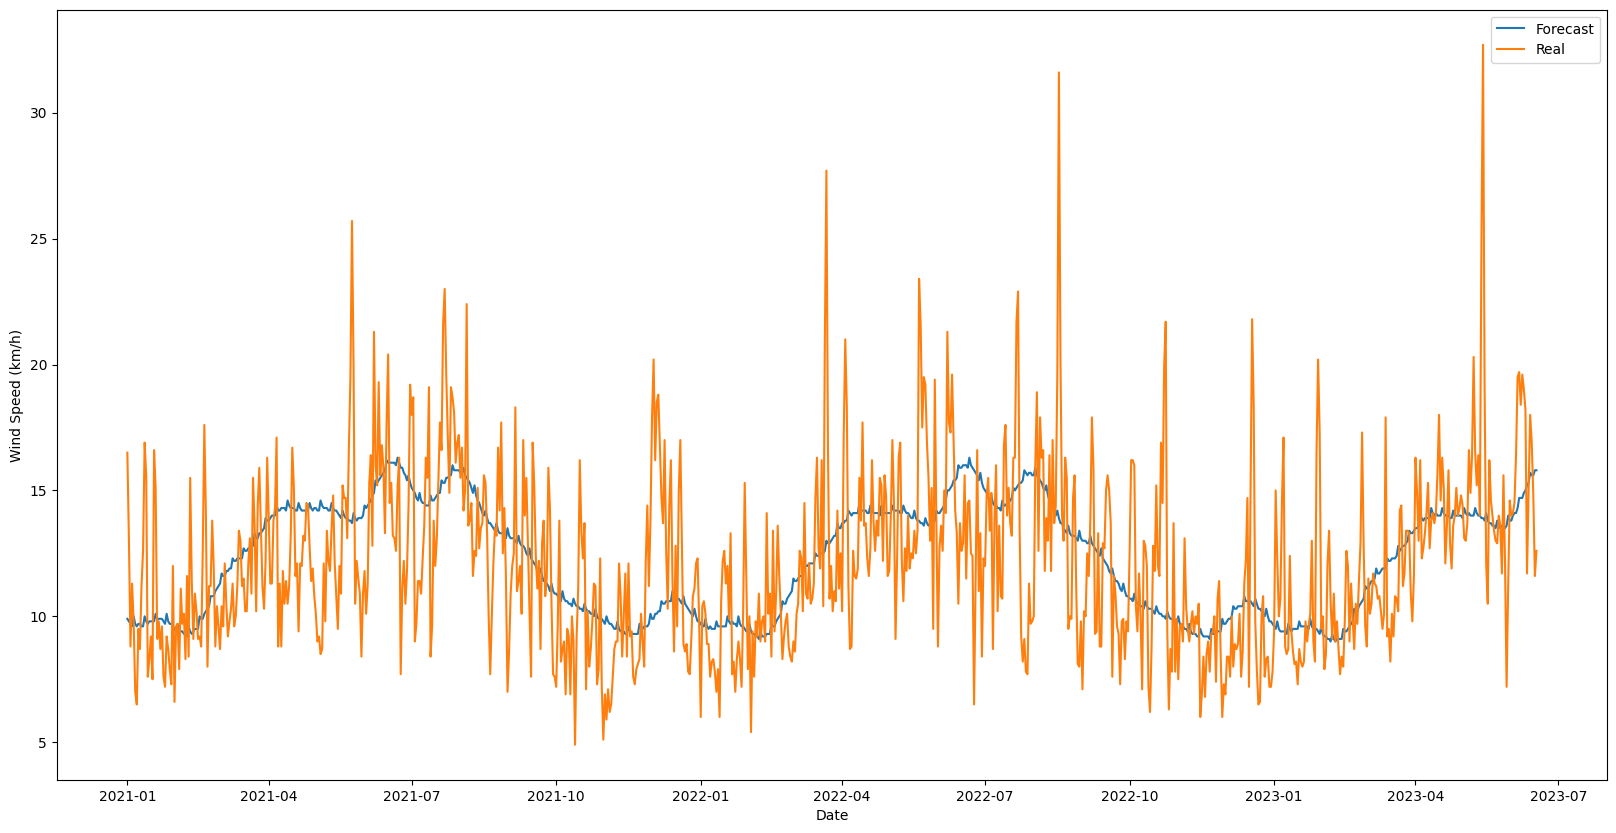

In [181]:
plt.figure(figsize=(20, 10))
plt.plot(forecast['date'], forecast['forecast'], label='Forecast')
plt.plot(forecast['date'], forecast['real'], label='Real')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Wind Speed (km/h)')
plt.show()

### Save Model

In [182]:
with open('windspeed_forecast.pkl', 'wb') as f:
    pickle.dump(model, f)